In [1]:
import deepxde as dde
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
dde.config.set_random_seed(1234)
dde.config.set_default_float("float64")

Set the default float type to float64


### 1. Specify the computational domain using the geometry module.

In [3]:
geom = dde.geometry.Rectangle([0, 0], [2, 2])

timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

### 2. Specify the PDE using the grammar of TensorFlow.

In [4]:
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=2)
    
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    return du_t - ((1/3)**2) * (du_xx+du_yy)

### 3. Specify the boundary and/or initial conditions.

In [5]:
bc = dde.icbc.DirichletBC(geomtime,
                                lambda x: 0, 
                                lambda x, on_boundary: on_boundary)

ic = dde.icbc.IC(geomtime,
                 lambda x: tf.where(tf.greater_equal(x[:,1:2], 1),
                                    tf.zeros_like(x[:, 1:2], dtype=tf.float32),
                                    tf.fill(tf.shape(x[:,1:2]), 50.0)),
                 lambda x, on_initial: on_initial)

### 4. Combine the geometry, PDE and boundary/initial conditions together into data.PDE or data.TimePDE.

In [6]:
data = dde.data.TimePDE(geomtime, 
                        pde, 
                        [bc,
                         ic],
                        num_domain=500, 
                        num_boundary=100, 
                        num_initial=100,
                        train_distribution='Sobol')

C:\anaconda\Lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn("The balance properties of Sobol' points require "
C:\anaconda\Lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn("The balance properties of Sobol' points require "
C:\anaconda\Lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+101=101. 
  warnings.warn("The balance properties of Sobol' points require "


In [106]:
data.train_x_all

array([[1.        , 1.        , 0.        ],
       [1.5       , 0.5       , 0.        ],
       [0.5       , 1.5       , 0.        ],
       ...,
       [0.62890625, 1.37890625, 0.09570312],
       [0.87890625, 0.12890625, 0.97070312],
       [1.87890625, 1.12890625, 0.47070312]])

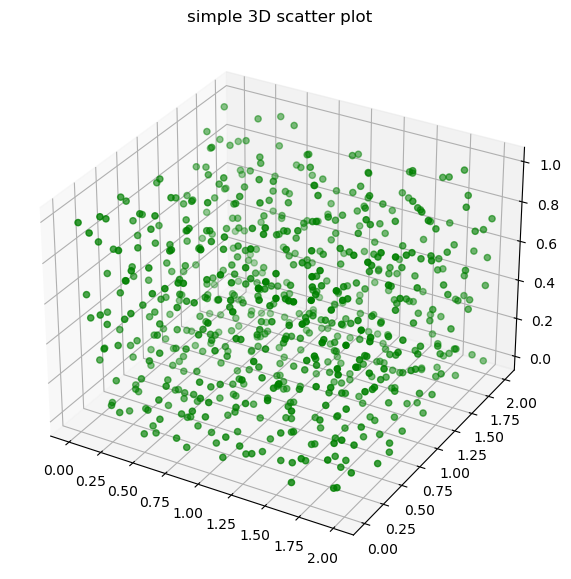

In [7]:
z = data.train_x_all[:,2]
x = data.train_x_all[:,0]
y = data.train_x_all[:,1]
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

### 5. Construct a neural network using the maps module.

In [8]:
net_square = dde.nn.FNN([3] + [20] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_long = dde.nn.FNN([3] + [20] * 5 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_oblong = dde.nn.FNN([3] + [5] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))

In [9]:
net_increasing = dde.nn.FNN([3] + [20] + [40] + [60] + [80] + [100]  + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_decreasing = dde.nn.FNN([3] + [100] + [80] + [60] + [40] + [20] + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))

### 6. Define a Model by combining the PDE problem in Step 4 and the neural netin Step 5.

In [10]:
model_square = dde.Model(data, net_square)
model_long = dde.Model(data, net_long)
model_oblong = dde.Model(data, net_oblong)

### 7. Call Model.compile to set the optimization hyperparameters, such as optimizer and learning rate.

### 8. Call Model.train to train the network from random initialization.

# Network Shape

In [11]:
model_square.compile("adam", lr=0.001)
model_square.train(iterations=10000)
model_square.compile("L-BFGS-B")
model_square.train(iterations=15000)

Compiling model...
Building feed-forward neural network...



C:\anaconda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.502214 s


'compile' took 3.254071 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.92e-02, 1.36e-02, 1.25e+03]    [4.92e-02, 1.36e-02, 1.25e+03]    []  
1000      [1.22e-10, 1.56e+02, 7.82e+02]    [1.22e-10, 1.56e+02, 7.82e+02]    []  
2000      [1.26e-08, 1.56e+02, 7.81e+02]    [1.26e-08, 1.56e+02, 7.81e+02]    []  
3000      [1.46e-11, 1.56e+02, 7.81e+02]    [1.46e-11, 1.56e+02, 7.81e+02]    []  
4000      [1.36e-11, 1.56e+02, 7.81e+02]    [1.36e-11, 1.56e+02, 7.81e+02]    []  
5000      [1.23e-11, 1.56e+02, 7.81e+02]    [1.23e-11, 1.56e+02, 7.81e+02]    []  
6000      [1.07e-11, 1.56e+02, 7.81e+02]    [1.07e-11, 1.56e+02, 7.81e+02]    []  
7000      [9.44e-12, 1.56e+02, 7.81e+02]    [9.44e-12, 1.56e+02, 7.81e+02]    []  
8000      [9.76e-12, 1.56e+02, 7.81e+02]    [9.76e-12, 1.56e+02, 7.81e+02]    []  
9000      [1.86e-11, 1.56e+02, 7.81e+02]    [1.86e-11, 1.56e+02, 7.81e+02]    []  
10000   

(<deepxde.model.LossHistory at 0x22c9e94d810>,
 <deepxde.model.TrainState at 0x22c9e94e4d0>)

In [11]:
model_long.compile("adam", lr=0.001)
model_long.train(iterations=10000)
model_long.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long.train(iterations=15000)

Compiling model...
Building feed-forward neural network...



C:\anaconda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.405113 s


'compile' took 1.939948 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.89e-02, 1.32e-01, 1.27e+03]    [1.89e-02, 1.32e-01, 1.27e+03]    []  
1000      [9.09e+00, 1.85e+01, 3.06e+02]    [9.09e+00, 1.85e+01, 3.06e+02]    []  
2000      [9.23e+00, 2.35e+01, 7.31e+01]    [9.23e+00, 2.35e+01, 7.31e+01]    []  
3000      [1.03e+01, 2.59e+01, 2.38e+01]    [1.03e+01, 2.59e+01, 2.38e+01]    []  
4000      [6.29e+00, 1.29e+01, 1.46e+01]    [6.29e+00, 1.29e+01, 1.46e+01]    []  
5000      [4.31e+00, 3.31e+00, 1.22e+01]    [4.31e+00, 3.31e+00, 1.22e+01]    []  
6000      [3.05e+00, 1.90e+00, 1.17e+01]    [3.05e+00, 1.90e+00, 1.17e+01]    []  
7000      [2.45e+00, 1.40e+00, 1.15e+01]    [2.45e+00, 1.40e+00, 1.15e+01]    []  
8000      [2.22e+00, 1.14e+00, 1.13e+01]    [2.22e+00, 1.14e+00, 1.13e+01]    []  
9000      [2.39e+00, 1.01e+00, 1.11e+01]    [2.39e+00, 1.01e+00, 1.11e+01]    []  
10000   

Saving loss history to heat_soft_long_loss ...


Text(0.5, 0, 'Epochs')

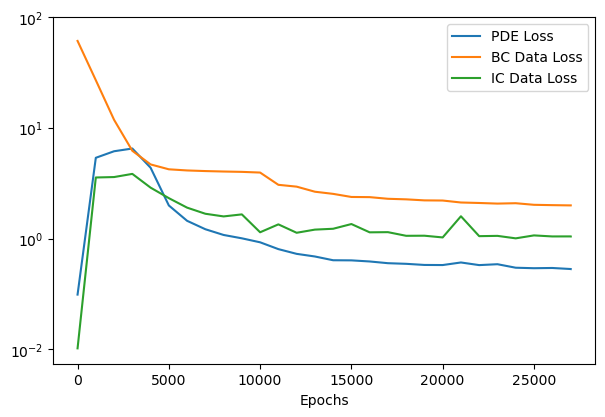

In [18]:
dde.utils.external.save_loss_history(loss_history_long, 'heat_soft_long_loss')
import pandas as pd
loss_long = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/heat_soft_long_loss", 
            delim_whitespace=True)

pde_loss = loss_long.to_numpy()[:,0]
bc_loss = loss_long.to_numpy()[:,1]
ic_loss = loss_long.to_numpy()[:,2]

epochs = np.arange(0,28000,1000)
epochs_array = np.append(epochs,27015)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])
ic_loss_array = np.append(ic_loss[:11], ic_loss[12:])

fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, np.log(pde_loss_array))
plt.plot(epochs_array, np.log(bc_loss_array))
plt.plot(epochs_array, np.log(ic_loss_array))
#plt.ylim(0.000001,1)
plt.yticks([8,4,0,-4], ['$10^{2}$','$10^{1}$','$10^{0}$','$10^{-2}$'])
plt.legend(['PDE Loss', 'BC Data Loss', 'IC Data Loss'])
plt.xlabel('Epochs')
#plt.savefig("laplace1_soft_loss_pic", bbox_inches = 'tight'

In [13]:
model_oblong.compile("adam", lr=0.001)
model_oblong.train(iterations=10000)
model_oblong.compile("L-BFGS-B")
model_oblong.train(iterations=15000)

Compiling model...
Building feed-forward neural network...
'build' took 0.562111 s

'compile' took 4.422992 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.74e-03, 7.83e-02, 1.26e+03]    [6.74e-03, 7.83e-02, 1.26e+03]    []  
1000      [1.93e-08, 6.96e+01, 9.03e+02]    [1.93e-08, 6.96e+01, 9.03e+02]    []  
2000      [9.78e-09, 1.29e+02, 8.11e+02]    [9.78e-09, 1.29e+02, 8.11e+02]    []  
3000      [4.44e-10, 1.53e+02, 7.85e+02]    [4.44e-10, 1.53e+02, 7.85e+02]    []  
4000      [4.53e-10, 1.56e+02, 7.81e+02]    [4.53e-10, 1.56e+02, 7.81e+02]    []  
5000      [4.90e-10, 1.56e+02, 7.81e+02]    [4.90e-10, 1.56e+02, 7.81e+02]    []  
6000      [5.62e-10, 1.56e+02, 7.81e+02]    [5.62e-10, 1.56e+02, 7.81e+02]    []  
7000      [7.17e-10, 1.56e+02, 7.81e+02]    [7.17e-10, 1.56e+02, 7.81e+02]    []  
8000      [1.16e-09, 1.56e+02, 7.81e+02]    [1.16e-09, 1.56e+02, 7.81e+02]    []  
9000      [1.21e-08, 1.56e+02, 7.

(<deepxde.model.LossHistory at 0x22c9e94f0d0>,
 <deepxde.model.TrainState at 0x22c9e94ff10>)

## Error

In [55]:
def u(x, y, t): 
    sum = 0
    for m in range(1,100):
        for n in range(1,100):
            sum = sum + (1/(m*n)) * (1+(-1)**(m+1)) * (1-np.cos(n*np.pi/2)) * np.sin(m*np.pi*x/2) * np.sin(n*np.pi*y/2) * np.exp(-(np.pi**2) * (m**2 + n**2)*t/36)
    return (200/(np.pi**2)) * sum  

In [26]:
u_exact = u(data.train_x_all.T[0][100:],
            data.train_x_all.T[1][100:],
            data.train_x_all.T[2][100:])

u_exact_hard = u(data2.train_x_all.T[0][100:],
            data2.train_x_all.T[1][100:],
            data2.train_x_all.T[2][100:])

In [27]:
u_square = model_square.predict(data.train_x_all[100:])
u_long = model_long.predict(data.train_x_all[100:])
u_oblong = model_oblong.predict(data.train_x_all[100:])

In [29]:
u_square2 = model_square2.predict(data2.train_x_all[100:])
u_long2 = model_long2.predict(data2.train_x_all[100:])
u_oblong2 = model_oblong2.predict(data2.train_x_all[100:])

In [31]:
print(dde.metrics.l2_relative_error(u_exact, u_square.T))
print(dde.metrics.l2_relative_error(u_exact, u_long.T))
print(dde.metrics.l2_relative_error(u_exact, u_oblong.T))

print(dde.metrics.l2_relative_error(u_exact_hard, u_square2.T))
print(dde.metrics.l2_relative_error(u_exact_hard, u_long2.T))
print(dde.metrics.l2_relative_error(u_exact_hard, u_oblong2.T))

0.14200497
0.15382607
0.34470597
0.6399247
0.11684969
0.6398608


## Plot

In [29]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 2, 0, 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()
    ))

In [30]:
test0 = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       np.full(shape=(len(points[0])), fill_value=0.1).reshape(len(points[0]),1)], axis=1)

test1 = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       np.full(shape=(len(points[0])), fill_value=0.5).reshape(len(points[0]),1)], axis=1)

test2 = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       np.full(shape=(len(points[0])), fill_value=1).reshape(len(points[0]),1)], axis=1)

In [60]:
#u_square_plot0 = model_square.predict(test0)
u_long_plot0 = model_long.predict(test0)
#u_oblong_plot0 = model_oblong.predict(test0)

#u_square_plot1 = model_square.predict(test1)
u_long_plot1 = model_long.predict(test1)
#u_oblong_plot1 = model_oblong.predict(test1)

#u_square_plot2 = model_square.predict(test2)
u_long_plot2 = model_long.predict(test2)
#u_oblong_plot2 = model_oblong.predict(test2)

#u_square_hard_plot0 = model_square2.predict(test0)
u_long_hard_plot0 = model_long2.predict(test0)
#u_oblong_hard_plot0 = model_oblong2.predict(test0)

#u_square_hard_plot1 = model_square2.predict(test1)
u_long_hard_plot1 = model_long2.predict(test1)
#u_oblong_hard_plot1 = model_oblong2.predict(test1)

#u_square_hard_plot2 = model_square2.predict(test2)
u_long_hard_plot2 = model_long2.predict(test2)
#u_oblong_hard_plot2 = model_oblong2.predict(test2)

u_exact_plot0 = u(points[0],
                  points[1],
                  np.full(shape=(len(points[0]),), fill_value=0.1) )

u_exact_plot1 = u(points[0],
                  points[1],
                  np.full(shape=(len(points[0]),), fill_value=0.5) )

u_exact_plot2 = u(points[0],
                  points[1],
                  np.full(shape=(len(points[0]),), fill_value=1) )

In [61]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

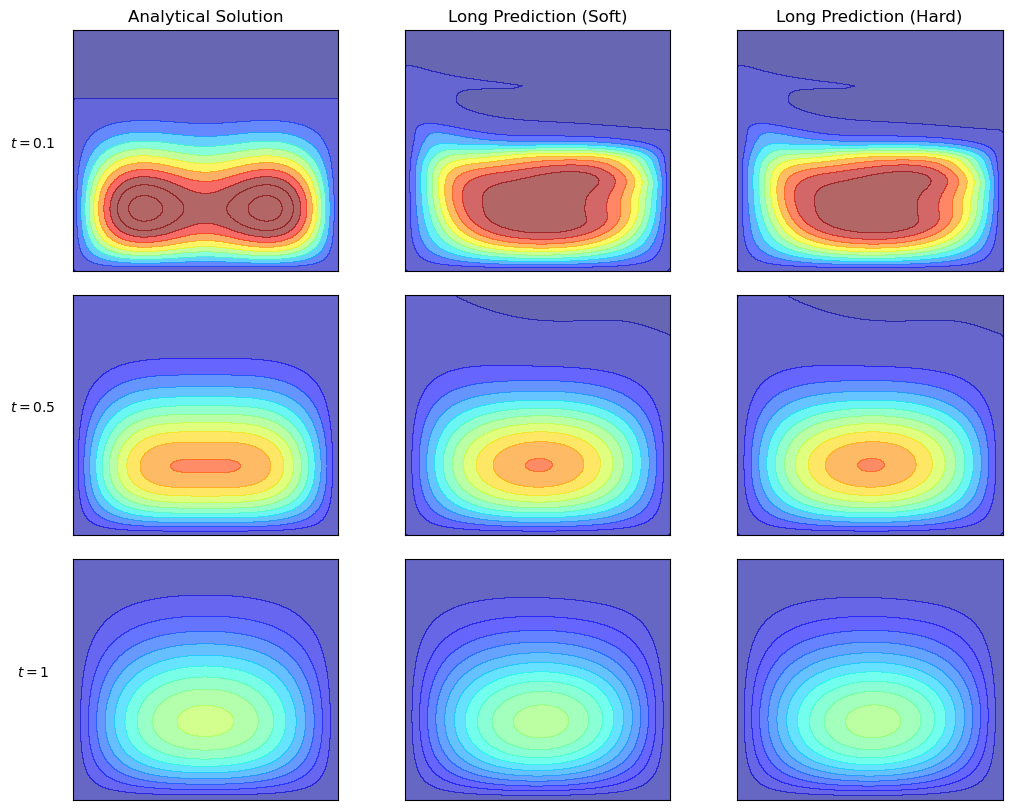

In [103]:
fig = plt.figure(figsize=(12,10))
vmin=0
vmax=50

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(3,3,1)
ax1.contourf(plot_grid[0], plot_grid[1], u_exact_plot0.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax1.set_ylabel('$t = 0.1$', rotation=0)
ax1.yaxis.set_label_coords(-.15, .5)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Analytical Solution');
#IMAGE 2
ax2 = fig.add_subplot(3,3,2)
ax2.contourf(plot_grid[0], plot_grid[1], u_long_plot0.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Long Prediction (Soft)');

#IMAGE 2
ax3 = fig.add_subplot(3,3,3)
ax3.contourf(plot_grid[0], plot_grid[1], u_long_hard_plot0.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Long Prediction (Hard)');

#IMAGE 3
#ax3 = fig.add_subplot(3,3,3)
#error_long_0 = 1*np.abs(u_long_plot0.reshape((Nx,Ny)) - u_exact_plot0.reshape((Nx,Ny)))
#ax3.contourf(plot_grid[0], plot_grid[1], error_long_0, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
#ax3.set_xticks([])
#ax3.set_yticks([])
#ax3.set_title('Error');

#ROW 2
#IMAGE 1
ax4 = fig.add_subplot(3,3,4)
ax4.contourf(plot_grid[0], plot_grid[1], u_exact_plot1.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax4.set_ylabel('$t = 0.5$', rotation=0)
ax4.yaxis.set_label_coords(-.15, .5)
ax4.set_xticks([])
ax4.set_yticks([])
#IMAGE 2
ax5 = fig.add_subplot(3,3,5)
ax5.contourf(plot_grid[0], plot_grid[1], u_long_plot1.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax5.set_xticks([])
ax5.set_yticks([])
#IMAGE 3
ax6 = fig.add_subplot(3,3,6)
ax6.contourf(plot_grid[0], plot_grid[1], u_long_hard_plot1.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax6.set_xticks([])
ax6.set_yticks([])
#ax6 = fig.add_subplot(3,3,6)
#error_long_1 = 1*np.abs(u_long_plot1.reshape((Nx,Ny)) - u_exact_plot1.reshape((Nx,Ny)))
#ax6.contourf(plot_grid[0], plot_grid[1], error_long_1, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
#ax6.set_xticks([])
#ax6.set_yticks([])
#ax6.set_title('Error');

#ROW 3
#IMAGE 1
ax7 = fig.add_subplot(3,3,7)
ax7.contourf(plot_grid[0], plot_grid[1], u_exact_plot2.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax7.set_ylabel('$t = 1$', rotation=0)
ax7.yaxis.set_label_coords(-.15, .5)
ax7.set_xticks([])
ax7.set_yticks([])
#IMAGE 2
ax8 = fig.add_subplot(3,3,8)
ax8.contourf(plot_grid[0], plot_grid[1], u_long_plot2.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax8.set_xticks([])
ax8.set_yticks([])
#IMAGE 3
ax9 = fig.add_subplot(3,3,9)
ax9.contourf(plot_grid[0], plot_grid[1], u_long_hard_plot2.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=50, levels=10)
ax9.set_xticks([])
ax9.set_yticks([])
#ax9 = fig.add_subplot(3,3,9)
#error_long_2 = 1*np.abs(u_long_plot2.reshape((Nx,Ny)) - u_exact_plot2.reshape((Nx,Ny)))
#ax9.contourf(plot_grid[0], plot_grid[1], error_long_2, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
#ax9.set_xticks([])
#ax9.set_yticks([])
#ax9.set_title('Error');

plt.subplots_adjust(hspace=0.1, wspace=0.25)
#plt.savefig("burger_shape_error", bbox_inches = 'tight')

# Hard Constraint

In [19]:
ic = dde.icbc.IC(geomtime,
                 lambda x: tf.where(tf.greater_equal(x[:,1:2], 1),
                                    tf.zeros_like(x[:, 1:2], dtype=tf.float32),
                                    tf.fill(tf.shape(x[:,1:2]), 50.0)),
                 lambda x, on_initial: on_initial)

In [20]:
data2 = dde.data.TimePDE(geomtime, 
                        pde, 
                         [ic],
                        num_domain=500,
                        num_initial=100,
                        train_distribution='Sobol')

C:\anaconda\Lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+502=502. 
  warnings.warn("The balance properties of Sobol' points require "
C:\anaconda\Lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+101=101. 
  warnings.warn("The balance properties of Sobol' points require "


In [21]:
net_square2 = dde.nn.FNN([3] + [20] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_long2 = dde.nn.FNN([3] + [20] * 5 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_oblong2 = dde.nn.FNN([3] + [5] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))

In [24]:
def output_transform(x,u):
        return x[:,0:1] * ( 2 - x[:,0:1] ) * x[:,1:2] * ( 2 - x[:,1:2] ) * u

In [25]:
net_square2.apply_output_transform(output_transform)
model_square2 = dde.Model(data2, net_square2)

net_long2.apply_output_transform(output_transform)
model_long2 = dde.Model(data2, net_long2)

net_oblong2.apply_output_transform(output_transform)
model_oblong2 = dde.Model(data2, net_oblong2)

In [19]:
model_square2.compile("adam", lr=0.001)
model_square2.train(iterations=10000)
model_square2.compile("L-BFGS-B")
model_square2.train(iterations=15000)

Compiling model...
Building feed-forward neural network...
'build' took 0.395518 s

'compile' took 3.921752 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.10e-02, 1.25e+03]    [2.10e-02, 1.25e+03]    []  
1000      [4.63e+01, 8.94e+02]    [4.63e+01, 8.94e+02]    []  
2000      [7.77e+01, 8.42e+02]    [7.77e+01, 8.42e+02]    []  
3000      [8.26e+01, 8.37e+02]    [8.26e+01, 8.37e+02]    []  
4000      [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  
5000      [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  
6000      [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  
7000      [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  
8000      [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  
9000      [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  
10000     [8.28e+01, 8.37e+02]    [8.28e+01, 8.37e+02]    []  

Best model at step 10000:
  train loss: 9.20e+02
  test loss: 9.20e+02
  test metric: []

'train' took 192

(<deepxde.model.LossHistory at 0x22cac12b250>,
 <deepxde.model.TrainState at 0x22ca9ff2390>)

In [26]:
model_long2.compile("adam", lr=0.001)
model_long2.train(iterations=10000)
model_long2.compile("L-BFGS-B")
loss_history_long2, train_state_long2 = model_long2.train(iterations=15000)

Compiling model...
Building feed-forward neural network...
'build' took 0.195093 s



C:\anaconda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.880736 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.12e-02, 1.26e+03]    [3.12e-02, 1.26e+03]    []  
1000      [2.44e+00, 7.70e+02]    [2.44e+00, 7.70e+02]    []  
2000      [1.89e+00, 5.51e+02]    [1.89e+00, 5.51e+02]    []  
3000      [2.38e+00, 4.38e+02]    [2.38e+00, 4.38e+02]    []  
4000      [2.37e+00, 3.82e+02]    [2.37e+00, 3.82e+02]    []  
5000      [2.53e+00, 3.62e+02]    [2.53e+00, 3.62e+02]    []  
6000      [2.87e+00, 3.57e+02]    [2.87e+00, 3.57e+02]    []  
7000      [1.97e+00, 3.54e+02]    [1.97e+00, 3.54e+02]    []  
8000      [2.45e+00, 3.45e+02]    [2.45e+00, 3.45e+02]    []  
9000      [5.33e+00, 2.93e+02]    [5.33e+00, 2.93e+02]    []  
10000     [1.10e+01, 2.84e+02]    [1.10e+01, 2.84e+02]    []  

Best model at step 10000:
  train loss: 2.95e+02
  test loss: 2.95e+02
  test metric: []

'train' took 72.783549 s

Compiling model...
'compile' took 1.211887 s

Training model...

Step     

Saving loss history to heat_hard_long_loss ...


Text(0.5, 0, 'Epochs')

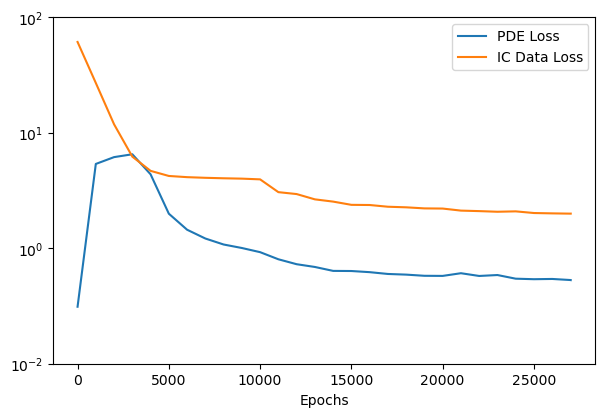

In [28]:
dde.utils.external.save_loss_history(loss_history_long, 'heat_hard_long_loss')
import pandas as pd
loss_long = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/heat_hard_long_loss", 
            delim_whitespace=True)

pde_loss = loss_long.to_numpy()[:,0]
ic_loss = loss_long.to_numpy()[:,1]

epochs = np.arange(0,28000,1000)
epochs_array = np.append(epochs,27015)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
ic_loss_array = np.append(ic_loss[:11], ic_loss[12:])

fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, np.log(pde_loss_array))
plt.plot(epochs_array, np.log(ic_loss_array))
#plt.ylim(0.000001,1)
plt.yticks([8,4,0,-4], ['$10^{2}$','$10^{1}$','$10^{0}$','$10^{-2}$'])
plt.legend(['PDE Loss','IC Data Loss'])
plt.xlabel('Epochs')
#plt.savefig("laplace1_soft_loss_pic", bbox_inches = 'tight'

In [23]:
model_oblong2.compile("adam", lr=0.001)
model_oblong2.train(iterations=10000)
model_oblong2.compile("L-BFGS-B")
model_oblong2.train(iterations=15000)

Compiling model...
Building feed-forward neural network...
'build' took 1.021229 s

'compile' took 11.522770 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.08e-02, 1.26e+03]    [1.08e-02, 1.26e+03]    []  
1000      [8.05e+00, 1.07e+03]    [8.05e+00, 1.07e+03]    []  
2000      [2.00e+01, 9.85e+02]    [2.00e+01, 9.85e+02]    []  
3000      [3.48e+01, 9.26e+02]    [3.48e+01, 9.26e+02]    []  
4000      [5.06e+01, 8.85e+02]    [5.06e+01, 8.85e+02]    []  
5000      [6.54e+01, 8.58e+02]    [6.54e+01, 8.58e+02]    []  
6000      [7.04e+01, 8.51e+02]    [7.04e+01, 8.51e+02]    []  
7000      [7.58e+01, 8.44e+02]    [7.58e+01, 8.44e+02]    []  
8000      [8.01e+01, 8.40e+02]    [8.01e+01, 8.40e+02]    []  
9000      [8.22e+01, 8.37e+02]    [8.22e+01, 8.37e+02]    []  
10000     [8.27e+01, 8.37e+02]    [8.27e+01, 8.37e+02]    []  

Best model at step 10000:
  train loss: 9.20e+02
  test loss: 9.20e+02
  test metric: []

'train' took 26

(<deepxde.model.LossHistory at 0x22ca9ff0e90>,
 <deepxde.model.TrainState at 0x22ca9ff07d0>)

In [69]:
def u(x, y, t): 
    sum = 0
    for m in range(1,5):
        for n in range(1,5):
            sum = sum + (1/(m*n)) * (1+(-1)**(m+1)) * (1-np.cos(n*np.pi/2)) * np.sin(m*np.pi*x/2) * np.sin(n*np.pi*y/2) * np.exp(-(np.pi**2) * (m**2 + n**2)*t/36)
    return (200/(np.pi**2)) * sum  

u_exact = u(data2.train_x_all.T[0][100:],
            data2.train_x_all.T[1][100:],
            data2.train_x_all.T[2][100:])

In [82]:
Nx = 100
Ny = 100
Nt = 100

xmin, xmax, ymin, ymax, tmin, tmax = [0, 2, 0, 2, 0.1, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j, tmin : tmax : Nt * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel(),
    plot_grid[2].ravel()
    ))

In [83]:
test = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       points[2].reshape(len(points[0]),1)
                      ], axis=1)

In [84]:
u_long2 = model_long2.predict(test)
u_exact = u(points[0].T,
            points[1].T,
            points[2].T)
print(dde.metrics.l2_relative_error(u_exact, u_long2.T))

0.14358742019269058


## Plots

In [89]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 2, 0, 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()
    ))

In [90]:
test0 = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       np.full(shape=(len(points[0])), fill_value=0.1).reshape(len(points[0]),1)], axis=1)

test1 = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       np.full(shape=(len(points[0])), fill_value=0.5).reshape(len(points[0]),1)], axis=1)

test2 = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1),
                       np.full(shape=(len(points[0])), fill_value=1).reshape(len(points[0]),1)], axis=1)

In [94]:
#u_square_hard_plot0 = model_square2.predict(test0)
u_long_plot0 = model_long2.predict(test0)
#u_oblong_plot0 = model_oblong.predict(test0)

#u_square_hard_plot1 = model_square2.predict(test1)
u_long_plot1 = model_long2.predict(test1)
#u_oblong_plot1 = model_oblong.predict(test1)

#u_square_hard_plot2 = model_square2.predict(test2)
u_long_plot2 = model_long2.predict(test2)
#u_oblong_plot2 = model_oblong.predict(test2)

u_exact_plot0 = u(points[0],
                  points[1],
                  np.full(shape=(len(points[0]),), fill_value=0.1) )

u_exact_plot1 = u(points[0],
                  points[1],
                  np.full(shape=(len(points[0]),), fill_value=0.5) )

u_exact_plot2 = u(points[0],
                  points[1],
                  np.full(shape=(len(points[0]),), fill_value=1) )

In [95]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 10}
plt.rc('font', **font)

Text(0.5, 0.92, 'PINN Solution')

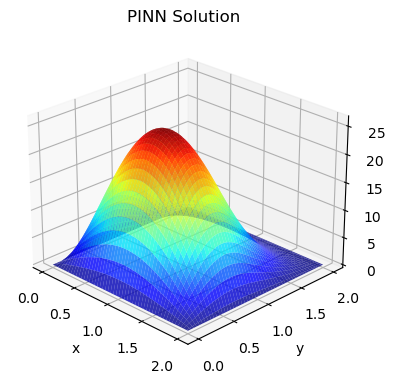

In [98]:
plt.figure(figsize=(4.5,4.5))
ax = plt.axes(projection='3d')

ax.plot_surface(plot_grid[0], plot_grid[1], u_long_plot2.reshape((Nx,Ny)), cmap='jet',linewidth=0, alpha = 0.8, zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_2
ax.view_init(*init_view)
ax.set_title('PINN Solution', pad=-20)
#ax.set_xticks([0,0.25,0.5,0.75,1])
#ax.set_yticks([0,0.25,0.5,0.75,1])
#ax.set_zticks([0,0.25,0.5,0.75,1])

#plt.savefig("4x128_pinn_bc1.png", bbox_inches = 'tight')